<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/LSTM_Rainfall_Forecasting_%E2%80%93_Direct_vs_Recursive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM Rainfall Forecasting – Direct vs. Recursive
https://chatgpt.com/share/68ba458d-d7a0-8010-b0de-3055c31250e7

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training Direct Multi-Step Model...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1929 - val_loss: 0.0316
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0265 - val_loss: 0.0194
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0210 - val_loss: 0.0162
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0177 - val_loss: 0.0154
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0135 - val_loss: 0.0119
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 12/20
22/22 ━━━━━━━━

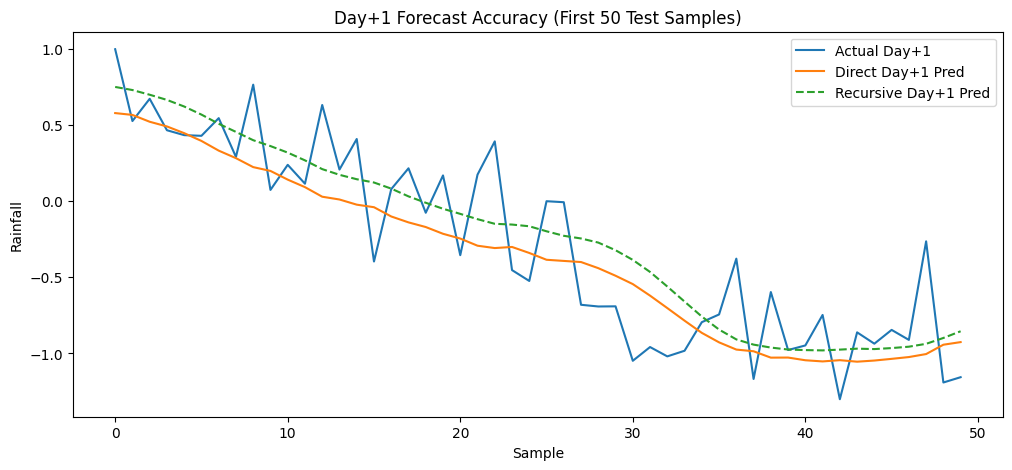

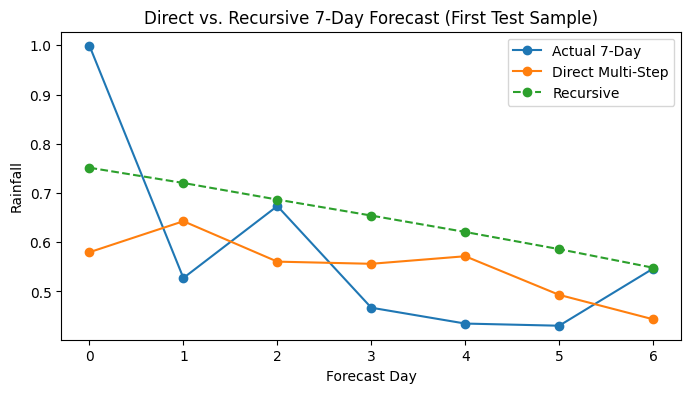

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------
# 1. Generate Synthetic Data
# ---------------------------
np.random.seed(42)
days = 1000
rain = np.sin(np.linspace(0, 50, days)) + 0.3 * np.random.randn(days)
rain = rain.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(rain)

# ---------------------------
# 2. Create Sliding Windows
# ---------------------------
window_size = 30
forecast_horizon = 7

# Multi-step dataset
X_multi, y_multi = [], []
for i in range(len(rain_scaled) - window_size - forecast_horizon):
    X_multi.append(rain_scaled[i:i+window_size])
    y_multi.append(rain_scaled[i+window_size:i+window_size+forecast_horizon].flatten())
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

# Single-step dataset
X_single, y_single = [], []
for i in range(len(rain_scaled) - window_size):
    X_single.append(rain_scaled[i:i+window_size])
    y_single.append(rain_scaled[i+window_size])
X_single = np.array(X_single)
y_single = np.array(y_single)

# ---------------------------
# 3. Train/Test Split
# ---------------------------
split_multi = int(0.8 * len(X_multi))
X_train_multi, X_test_multi = X_multi[:split_multi], X_multi[split_multi:]
y_train_multi, y_test_multi = y_multi[:split_multi], y_multi[split_multi:]

split_single = int(0.8 * len(X_single))
X_train_single, X_test_single = X_single[:split_single], X_single[split_single:]
y_train_single, y_test_single = y_single[:split_single], y_single[split_single:]

# ---------------------------
# 4. Build Models
# ---------------------------
# Direct Multi-Step Model
model_multi = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(forecast_horizon)
])
model_multi.compile(optimizer='adam', loss='mse')

# Iterative (Single-Step) Model
model_single = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_single.compile(optimizer='adam', loss='mse')

# ---------------------------
# 5. Train Models
# ---------------------------
print("\nTraining Direct Multi-Step Model...")
model_multi.fit(X_train_multi, y_train_multi, epochs=20, batch_size=32,
                validation_split=0.1, verbose=1)

print("\nTraining Iterative Single-Step Model...")
model_single.fit(X_train_single, y_train_single, epochs=20, batch_size=32,
                 validation_split=0.1, verbose=1)

# ---------------------------
# 6. Predict with Both Models
# ---------------------------
# Direct multi-step prediction
pred_multi = model_multi.predict(X_test_multi)
pred_multi_rescaled = scaler.inverse_transform(pred_multi)
y_test_multi_rescaled = scaler.inverse_transform(y_test_multi)

# Iterative recursive prediction
def recursive_forecast(model, input_seq, n_steps=7):
    forecast = []
    seq = input_seq.copy()
    for _ in range(n_steps):
        pred = model.predict(seq.reshape(1, window_size, 1), verbose=0)
        forecast.append(pred[0, 0])
        seq = np.vstack([seq[1:], pred])
    return np.array(forecast)

recursive_forecasts = []
for i in range(len(X_test_multi)):
    fcast = recursive_forecast(model_single, X_test_multi[i], forecast_horizon)
    recursive_forecasts.append(fcast)
recursive_forecasts = np.array(recursive_forecasts)

recursive_rescaled = scaler.inverse_transform(recursive_forecasts)
# Note: y_test_multi is correct for comparison

# ---------------------------
# 7. Plot Comparisons
# ---------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test_multi_rescaled[:50, 0], label="Actual Day+1")
plt.plot(pred_multi_rescaled[:50, 0], label="Direct Day+1 Pred")
plt.plot(recursive_rescaled[:50, 0], label="Recursive Day+1 Pred", linestyle='dashed')
plt.title("Day+1 Forecast Accuracy (First 50 Test Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall")
plt.legend()
plt.show()

# Plot full 7-day forecast for first test case
plt.figure(figsize=(8, 4))
plt.plot(y_test_multi_rescaled[0], 'o-', label="Actual 7-Day")
plt.plot(pred_multi_rescaled[0], 'o-', label="Direct Multi-Step")
plt.plot(recursive_rescaled[0], 'o--', label="Recursive")
plt.title("Direct vs. Recursive 7-Day Forecast (First Test Sample)")
plt.xlabel("Forecast Day")
plt.ylabel("Rainfall")
plt.legend()
plt.show()